# Introduction to RNNs, LSTMs, and Attention in Healthcare

## 1. Setup and Installation

In [2]:
# Install required packages (run this cell)
!pip install numpy pandas matplotlib seaborn scikit-learn torch tqdm

## 2. Introduction
> Welcome!

> In this notebook, we will explore Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and the concept of attention in sequence modeling.

> We will use a real-world dataset, build models, visualize their behavior, and see how attention can improve performance.

## 3. Data Download and Exploration

> For demonstration, we’ll use a public healthcare time series dataset (a subset of the PhysioNet MIMIC-III dataset).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import time

def download_physionet_data():
    """Download PhysioNet Challenge 2012 dataset"""
    base_url = "https://physionet.org/files/challenge-2012/1.0.0/"
    
    # Create data directory if it doesn't exist
    if not os.path.exists('physionet_data'):
        os.makedirs('physionet_data')
    
    # Download the dataset files 
    files = ['set-a.zip', 'set-b.zip']  
    
    for file in files:
        file_path = f'physionet_data/{file}'
        if not os.path.exists(file_path) or os.path.getsize(file_path) < 1000000:  # Check if file is too small (error page)
            print(f"Downloading {file}...")
            url = base_url + file
            try:
                response = requests.get(url, timeout=30)
                response.raise_for_status()  # Raise an error for bad status codes
                
                # Check if we got an HTML page instead of a zip file
                if response.content[:100].decode('utf-8', errors='ignore').startswith('<!DOCTYPE') or \
                   response.content[:100].decode('utf-8', errors='ignore').startswith('<html'):
                    print(f"Warning: {file} download returned HTML page (authentication required)")
                    continue
                
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                
                # Verify it's a valid zip file
                try:
                    with zipfile.ZipFile(file_path, 'r') as zip_ref:
                        zip_ref.extractall('physionet_data')
                    print(f"Successfully downloaded and extracted {file}")
                except zipfile.BadZipFile:
                    print(f"Warning: {file} is not a valid zip file")
                    os.remove(file_path)  # Remove the invalid file
                    continue
                    
            except Exception as e:
                print(f"Error downloading {file}: {e}")
                continue

def hhmm_to_hours(t):
    """Parse HH:MM time strings to hours (handles hours >= 24)"""
    h, m = map(int, t.split(':'))
    return h + m/60

def load_physionet_data():
    """Load and preprocess PhysioNet Challenge 2012 data"""
    # Load the data files
    data_files = []
    for set_name in ['set-a', 'set-b']:  
        set_path = f'physionet_data/{set_name}'
        if os.path.exists(set_path):
            for file in os.listdir(set_path):
                if file.endswith('.txt'):
                    data_files.append(os.path.join(set_path, file))
    
    if not data_files:
        print("No data files found. Please run download_physionet_data() first.")
        return None
    
    print(f"Found {len(data_files)} patient files")
    
    # Load all patient data
    all_patients = []
    outcomes = {}
    
    # Load outcomes file if available
    outcomes_file = 'physionet_data/Outcomes-a.txt'
    if os.path.exists(outcomes_file):
        print("Loading outcomes file...")
        with open(outcomes_file, 'r') as f:
            lines = f.readlines()
            for line in lines[1:]:  # Skip header
                parts = line.strip().split(',')
                if len(parts) >= 6:
                    patient_id = parts[0]
                    outcome = int(parts[5])  # In-hospital death
                    outcomes[patient_id] = outcome
    
    # Define vital signs and metadata parameters to exclude
    vital_signs = ['HR', 'NISysABP', 'NIDiasABP', 'Temp', 'RespRate']
    metadata_params = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
    
    # Load patient time series data
    processed_count = 0
    for file_path in data_files:  # Process all patients
        patient_id = os.path.basename(file_path).replace('.txt', '')
        
        try:
            # Read patient data using pandas with proper parsing
            df_patient = pd.read_csv(file_path, header=0)  # First row is header
            
            # Filter out metadata parameters early
            df_patient = df_patient[~df_patient['Parameter'].isin(metadata_params)]
            
            # Parse time strings manually to handle hours >= 24
            df_patient['Time_hours'] = df_patient['Time'].apply(hhmm_to_hours)
            
            # Filter out non-numeric values and convert to numeric
            df_patient['Value'] = pd.to_numeric(df_patient['Value'], errors='coerce')
            df_patient = df_patient.dropna(subset=['Value', 'Time_hours'])
            
            if len(df_patient) == 0:
                continue
            
            # Bin to whole-hour slots before pivoting
            df_patient['hour'] = df_patient['Time_hours'].astype(int)  # 0, 1, 2, ... 47
            
            # Group by hour and parameter, take mean, then pivot
            df_hourly = (
                df_patient
                .groupby(['hour', 'Parameter'])['Value']
                .mean()
                .reset_index()
                .pivot(index='hour', columns='Parameter', values='Value')
            )
            
            # Select only vital signs and keep first 24 hours
            available_signs = [col for col in vital_signs if col in df_hourly.columns]
            
            if len(available_signs) >= 2:  # Need at least 2 vital signs
                df_hourly = df_hourly[available_signs].loc[:23]  # First 24 h only
                
                # Fill gaps within those 24 hours
                df_hourly = df_hourly.ffill().bfill()
                
                # Check if we have enough data
                non_nan_counts = df_hourly.notna().sum()
                if non_nan_counts.max() >= 2:  # At least 2 time points with data
                    # Ensure we have exactly 24 hours
                    if len(df_hourly) < 24:
                        # Pad with the last value if needed
                        missing_hours = 24 - len(df_hourly)
                        for i in range(missing_hours):
                            df_hourly.loc[len(df_hourly)] = df_hourly.iloc[-1]
                    
                    patient_dict = {'patient_id': patient_id}
                    for sign in available_signs:
                        if sign in df_hourly.columns:
                            patient_dict[sign] = df_hourly[sign].values
                    
                    # Add outcome if available
                    if patient_id in outcomes:
                        patient_dict['outcome'] = outcomes[patient_id]
                    else:
                        patient_dict['outcome'] = 0  # Default outcome
                    
                    all_patients.append(patient_dict)
                    processed_count += 1
                        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    print(f"Successfully processed {processed_count} patients")
    return pd.DataFrame(all_patients)

# Main execution
print("Downloading PhysioNet Challenge 2012 dataset...")
download_physionet_data()
df = load_physionet_data()

print(f"Loaded {len(df)} patients with time series data")
print(f"Columns: {list(df.columns)}")
print("\nSample of first patient's data:")
if len(df) > 0:
    print(f"Patient ID: {df.iloc[0]['patient_id']}")
    print(f"HR values (first 10): {df.iloc[0]['HR'][:10]}")
    print(f"NISysABP values (first 10): {df.iloc[0]['NISysABP'][:10]}")
    print(f"Outcome: {df.iloc[0]['outcome']}")

df.head()

Found 8000 patient files
Successfully processed 7859 patients
Loaded 7859 patients with time series data
Columns: ['patient_id', 'HR', 'NISysABP', 'NIDiasABP', 'Temp', 'RespRate', 'outcome']

Sample of first patient's data:
Patient ID: 132539
HR values (first 10): [75. 60. 62. 80. 74. 73. 64. 64. 66. 61.]
NISysABP values (first 10): [152. 137. 123. 114. 114. 110. 107. 102. 114. 109.]
Outcome: 0


,patient_id,HR,NISysABP,NIDiasABP,Temp,RespRate,outcome
0,132539,"[75.0, 60.0, 62.0, 80.0, 74.0, 73.0, 64.0, 64....","[152.0, 137.0, 123.0, 114.0, 114.0, 110.0, 107...","[61.5, 62.0, 52.0, 52.0, 52.0, 45.0, 49.0, 56....","[35.35, 35.35, 35.35, 37.8, 37.8, 37.8, 38.1, ...","[19.0, 18.0, 19.0, 20.0, 20.0, 17.0, 15.0, 14....",0
1,132540,"[88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88....","[105.33333333333333, 105.33333333333333, 105.3...","[54.333333333333336, 54.333333333333336, 54.33...","[34.88, 34.88, 35.4, 35.9, 36.7, 37.2, 37.4, 3...",NaN,0
2,132541,"[89.0, 96.0, 91.5, 86.0, 87.0, 94.5, 113.0, 95...","[132.0, 137.0, 135.5, 125.0, 134.0, 144.0, 138...","[83.5, 89.0, 85.5, 75.0, 72.0, 83.5, 79.0, 86....","[37.8, 37.8, 37.2, 37.2, 37.2, 37.2, 39.0, 39....",NaN,0
3,132543,"[76.33333333333333, 80.75, 75.33333333333333, ...","[127.66666666666667, 125.5, 125.66666666666667...","[65.0, 70.25, 71.0, 70.0, 68.0, 74.0, 61.0, 63...","[36.3, 36.3, 36.3, 36.4, 36.4, 36.4, 36.4, 36....","[18.0, 17.571428571428573, 15.666666666666666,...",0
4,132545,"[88.5, 94.0, 87.0, 82.0, 84.0, 86.0, 82.0, 83....","[145.0, 151.0, 130.0, 119.0, 139.3333333333333...","[45.5, 29.0, 44.0, 36.0, 41.0, 41.0, 34.0, 96....","[37.8, 37.8, 35.8, 35.8, 36.9, 37.0, 37.2, 37....","[24.0, 26.0, 20.0, 19.0, 20.0, 18.0, 17.0, 21....",0


## 4. Data Visualization

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

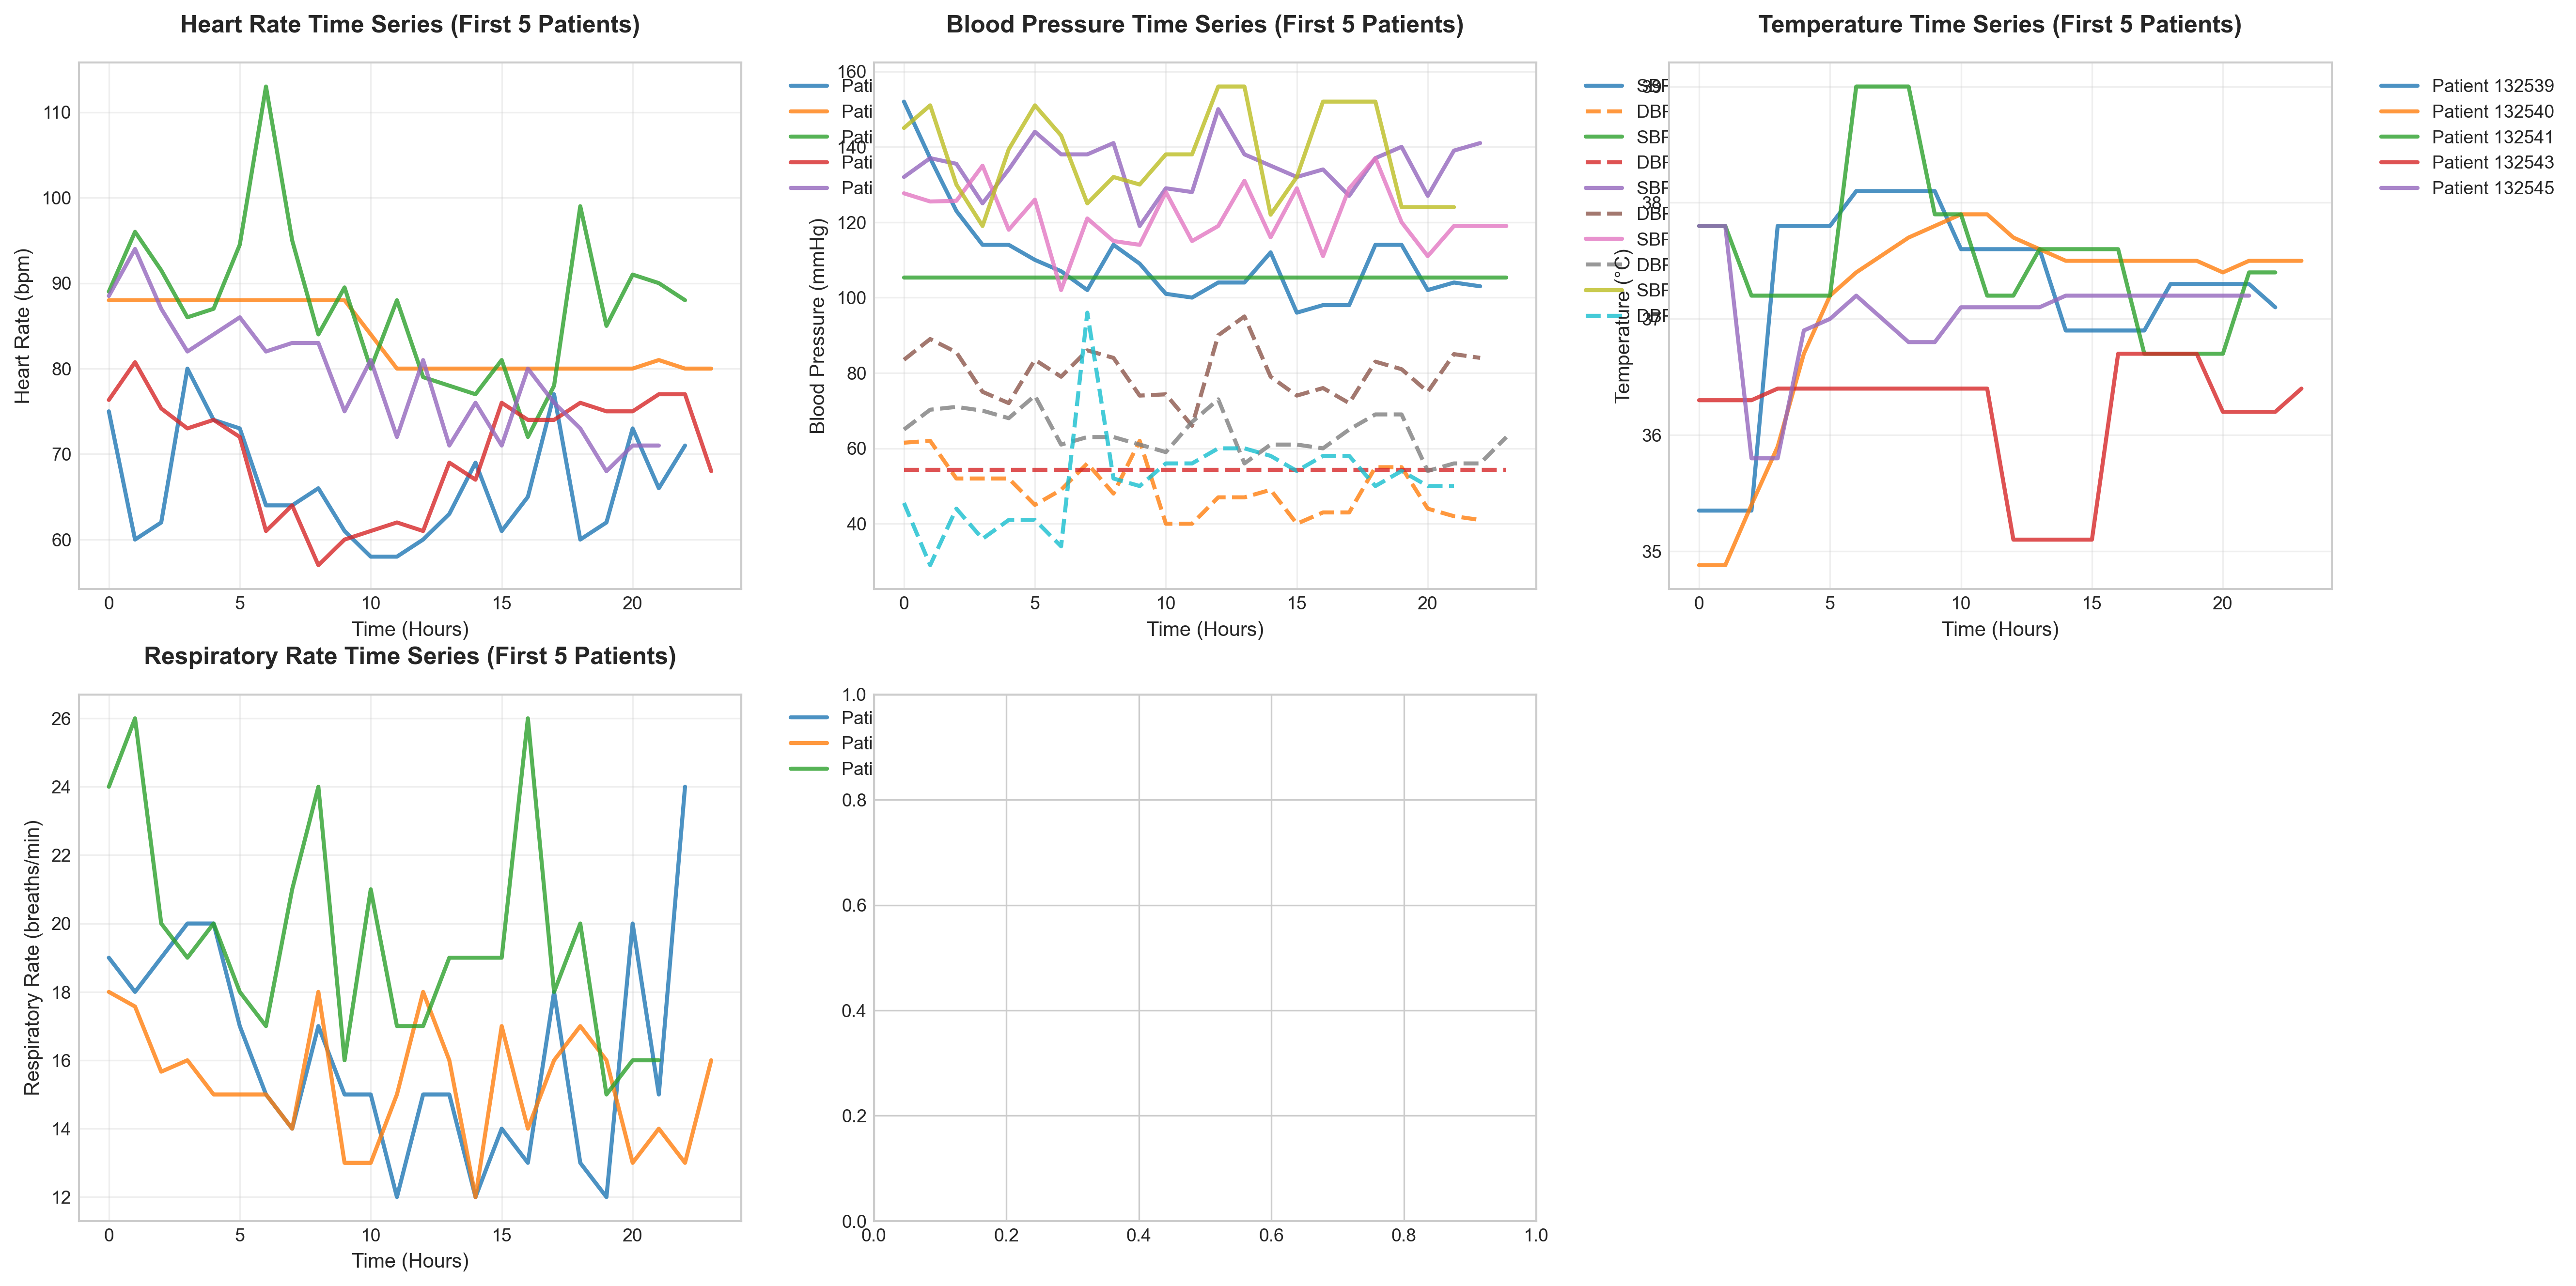

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

fig = plt.figure(figsize=(20, 16))

vital_signs = ['HR', 'NISysABP', 'NIDiasABP', 'Temp', 'RespRate']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# 1. Heart Rate Time Series for First 5 Patients
ax1 = plt.subplot(3, 3, 1)
for i in range(5):
    hr_data = df.iloc[i]['HR']
    if isinstance(hr_data, (list, np.ndarray)):
        hr_data = np.array(hr_data)
        x = np.arange(len(hr_data))
        ax1.plot(x, hr_data, linewidth=2, alpha=0.8, label=f'Patient {df.iloc[i]["patient_id"]}')
ax1.set_title('Heart Rate Time Series (First 5 Patients)', fontweight='bold', pad=15)
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel('Heart Rate (bpm)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Blood Pressure Time Series
ax2 = plt.subplot(3, 3, 2)
for i in range(5):
    sbp_data = df.iloc[i]['NISysABP']
    dbp_data = df.iloc[i]['NIDiasABP']
    if isinstance(sbp_data, (list, np.ndarray)) and isinstance(dbp_data, (list, np.ndarray)):
        sbp_data = np.array(sbp_data)
        dbp_data = np.array(dbp_data)
        x_sbp = np.arange(len(sbp_data))
        x_dbp = np.arange(len(dbp_data))
        ax2.plot(x_sbp, sbp_data, linewidth=2, alpha=0.8, label=f'SBP {df.iloc[i]["patient_id"]}')
        ax2.plot(x_dbp, dbp_data, linewidth=2, alpha=0.8, linestyle='--', label=f'DBP {df.iloc[i]["patient_id"]}')
ax2.set_title('Blood Pressure Time Series (First 5 Patients)', fontweight='bold', pad=15)
ax2.set_xlabel('Time (Hours)')
ax2.set_ylabel('Blood Pressure (mmHg)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Temperature Time Series
ax3 = plt.subplot(3, 3, 3)
for i in range(5):
    temp_data = df.iloc[i]['Temp']
    if isinstance(temp_data, (list, np.ndarray)):
        temp_data = np.array(temp_data)
        x = np.arange(len(temp_data))
        ax3.plot(x, temp_data, linewidth=2, alpha=0.8, label=f'Patient {df.iloc[i]["patient_id"]}')
ax3.set_title('Temperature Time Series (First 5 Patients)', fontweight='bold', pad=15)
ax3.set_xlabel('Time (Hours)')
ax3.set_ylabel('Temperature (°C)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Respiratory Rate Time Series
ax4 = plt.subplot(3, 3, 4)
for i in range(5):
    resp_data = df.iloc[i]['RespRate']
    if isinstance(resp_data, (list, np.ndarray)):
        resp_data = np.array(resp_data)
        x = np.arange(len(resp_data))
        ax4.plot(x, resp_data, linewidth=2, alpha=0.8, label=f'Patient {df.iloc[i]["patient_id"]}')
ax4.set_title('Respiratory Rate Time Series (First 5 Patients)', fontweight='bold', pad=15)
ax4.set_xlabel('Time (Hours)')
ax4.set_ylabel('Respiratory Rate (breaths/min)')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

def flatten_and_filter(values):
    """Flatten nested lists/arrays and filter out NaNs."""
    flat = []
    for v in values:
        if isinstance(v, (list, np.ndarray)):
            flat.extend([x for x in np.array(v).flatten() if not np.isnan(x)])
        elif v is not None and not np.isnan(v):
            flat.append(v)
    return flat

# 5. Distribution of Vital Signs
ax5 = plt.subplot(3, 3, 5)
for i, sign in enumerate(vital_signs):
    if sign in df.columns:
        # Extract all values for this vital sign
        all_values = []
        for _, row in df.iterrows():
            all_values.append(row[sign])
        all_values = flatten_and_filter(all_values)
        if len(all_values) > 0:
            ax5.hist(all_values, bins=30, alpha=0.7, color=colors[i], label=sign, density=True)

ax5.set_title('Distribution of Vital Signs', fontweight='bold', pad=15)
ax5.set_xlabel('Value')
ax5.set_ylabel('Density')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Correlation Heatmap of Vital Signs
ax6 = plt.subplot(3, 3, 6)
# Create correlation matrix from mean values
corr_data = []
for _, row in df.iterrows():
    patient_means = {}
    for sign in vital_signs:
        if sign in df.columns and isinstance(row[sign], list):
            values = [v for v in row[sign] if not np.isnan(v)]
            if values:
                patient_means[sign] = np.mean(values)
    if len(patient_means) == len(vital_signs):
        corr_data.append(patient_means)

if corr_data:
    corr_df = pd.DataFrame(corr_data)
    correlation_matrix = corr_df.corr()
    
    im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax6, shrink=0.8)
    plt.xticks(range(len(vital_signs)), vital_signs, rotation=45, ha='right')
    plt.yticks(range(len(vital_signs)), vital_signs)
    
    # Add correlation values as text
    for i in range(len(vital_signs)):
        for j in range(len(vital_signs)):
            plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                    ha='center', va='center', fontsize=8, fontweight='bold')

plt.title('Vital Signs Correlation Matrix', fontweight='bold', pad=15)

# 7. Outcome Distribution
ax7 = plt.subplot(3, 3, 7)
outcome_counts = df['outcome'].value_counts()
colors_outcome = ['#2E8B57', '#DC143C']
plt.pie(outcome_counts.values, labels=['Survived', 'Deceased'], autopct='%1.1f%%', 
        colors=colors_outcome, startangle=90, explode=(0.05, 0.05))
plt.title('Patient Outcome Distribution', fontweight='bold', pad=15)

# 8. Box Plot of Vital Signs by Outcome
ax8 = plt.subplot(3, 3, 8)
# Prepare data for box plot
box_data = []
box_labels = []
for sign in vital_signs:
    if sign in df.columns:
        for outcome in [0, 1]:
            values = []
            for _, row in df[df['outcome'] == outcome].iterrows():
                if isinstance(row[sign], list):
                    values.extend([v for v in row[sign] if not np.isnan(v)])
            if values:
                box_data.append(values)
                box_labels.append(f'{sign}\n({"Survived" if outcome == 0 else "Deceased"})')

if box_data:
    bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors_box = ['lightblue', 'lightcoral'] * (len(box_data) // 2)
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
    plt.xticks(rotation=45, ha='right')
    plt.title('Vital Signs Distribution by Outcome', fontweight='bold', pad=15)
    plt.ylabel('Value')

# 9. Time Series Heatmap (Average patterns)
ax9 = plt.subplot(3, 3, 9)
# Create average time series for each vital sign
time_series_data = []
for sign in vital_signs:
    if sign in df.columns:
        avg_series = np.zeros(24)
        count_series = np.zeros(24)
        for _, row in df.iterrows():
            if isinstance(row[sign], list):
                for hour, value in enumerate(row[sign]):
                    if not np.isnan(value):
                        avg_series[hour] += value
                        count_series[hour] += 1
        
        # Calculate average
        avg_series = np.where(count_series > 0, avg_series / count_series, np.nan)
        time_series_data.append(avg_series)

if time_series_data:
    time_series_array = np.array(time_series_data)
    im = plt.imshow(time_series_array, cmap='viridis', aspect='auto')
    plt.colorbar(im, ax=ax9, shrink=0.8)
    plt.xticks(range(0, 24, 4), range(0, 24, 4))
    plt.yticks(range(len(vital_signs)), vital_signs)
    plt.title('Average Vital Signs Patterns Over Time', fontweight='bold', pad=15)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Vital Signs')

plt.tight_layout()
plt.show()

# Additional summary statistics
print("\n" + "="*60)
print("DATASET SUMMARY STATISTICS")
print("="*60)
print(f"Total number of patients: {len(df)}")
print(f"Number of patients with outcome data: {len(df[df['outcome'].notna()])}")
print(f"Survival rate: {(df['outcome'] == 0).mean():.2%}")
print(f"Mortality rate: {(df['outcome'] == 1).mean():.2%}")

print("\nVital Signs Summary:")
for sign in vital_signs:
    if sign in df.columns:
        all_values = []
        for _, row in df.iterrows():
            if isinstance(row[sign], list):
                all_values.extend([v for v in row[sign] if not np.isnan(v)])
        if all_values:
            print(f"{sign}: Mean={np.mean(all_values):.2f}, Std={np.std(all_values):.2f}, "
                  f"Min={np.min(all_values):.2f}, Max={np.max(all_values):.2f}")

# Save the figure
plt.savefig('physionet_healthcare_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
print(f"\nFigure saved as 'physionet_healthcare_analysis.png'")

## 5. Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split

# Stack the time series into arrays
X = np.stack([np.stack([row['hr'], row['bp']], axis=1) for _, row in df.iterrows()])
y = df['outcome'].values

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

## 6. PyTorch Dataset and DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class PatientDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PatientDataset(X_train, y_train)
val_ds = PatientDataset(X_val, y_val)
test_ds = PatientDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

## 7. Defining an LSTM Model

In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return torch.sigmoid(out).squeeze()
        
model = LSTMClassifier(input_dim=2, hidden_dim=32, num_layers=1, output_dim=1)

## 8. Training Protocol

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def evaluate(model, loader, criterion):
    model.eval()
    losses = []
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())
            all_preds.extend(y_pred.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return np.mean(losses), all_preds, all_labels

## 9. Training the Model

In [ ]:
n_epochs = 20
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## 10. Model Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion)
test_preds_bin = [1 if p > 0.5 else 0 for p in test_preds]
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy_score(test_labels, test_preds_bin):.4f}")
print(f"Test ROC AUC: {roc_auc_score(test_labels, test_preds):.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds_bin)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 11. Adding Attention to the LSTM

In [ ]:
class AttentionLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        attn_weights = torch.softmax(self.attn(out).squeeze(-1), dim=1)  # (batch, seq_len)
        context = torch.sum(out * attn_weights.unsqueeze(-1), dim=1)     # (batch, hidden_dim)
        out = self.fc(context)
        return torch.sigmoid(out).squeeze(), attn_weights

# Instantiate and train as before, but update training loop to handle attention output
model_attn = AttentionLSTMClassifier(input_dim=2, hidden_dim=32, num_layers=1, output_dim=1).to(device)

## 12. Visualizing Attention Weights

In [ ]:
# Get attention weights for a batch
model_attn.eval()
X_batch, y_batch = next(iter(test_loader))
X_batch = X_batch.to(device)
with torch.no_grad():
    y_pred, attn_weights = model_attn(X_batch)

# Visualize attention for the first patient in the batch
plt.figure(figsize=(10, 3))
plt.plot(attn_weights[0].cpu().numpy(), marker='o')
plt.title('Attention Weights Across Time Steps (Patient 0)')
plt.xlabel('Time Step')
plt.ylabel('Attention Weight')
plt.show()

## 13. Compare Performance: LSTM vs. LSTM+Attention

In [ ]:
# Train and evaluate the attention model as before, then compare metrics
# (Repeat training loop for model_attn, then compare ROC AUC, accuracy, etc.)

## 14. Discussion and Next Steps
> Summary:

> - We built and trained an LSTM for healthcare time series prediction.
> - We added attention to help the model focus on important time steps.
> - We visualized attention weights to interpret model decisions.
> - Next, we will explore the "Attention is All You Need" paper and the Transformer architecture.